This notebook was retroactively fixed after the relationship was understood between num_taps and _window_frequency in Demodulator.

In [1]:
%matplotlib inline
from scipy import signal
from kid_readout.measurement.io import npy
from kid_readout.roach import demodulator
from kid_readout.analysis.timeseries import binning

In [2]:
npd = npy.NumpyDirectory('/data/detectors/2016-12-07_165113_filterbank_bin_wideband/')

In [3]:
npd.node_names()

['StreamArray0',
 'ADCSnap1',
 'StreamArray2',
 'ADCSnap3',
 'StreamArray4',
 'ADCSnap5',
 'StreamArray6',
 'ADCSnap7',
 'StreamArray8',
 'ADCSnap9',
 'StreamArray10',
 'ADCSnap11',
 'StreamArray12',
 'ADCSnap13',
 'StreamArray14',
 'ADCSnap15',
 'StreamArray16',
 'ADCSnap17',
 'StreamArray18',
 'ADCSnap19',
 'StreamArray20',
 'ADCSnap21',
 'StreamArray22',
 'ADCSnap23',
 'StreamArray24',
 'ADCSnap25',
 'StreamArray26',
 'ADCSnap27',
 'StreamArray28',
 'ADCSnap29',
 'StreamArray30',
 'ADCSnap31',
 'StreamArray32',
 'ADCSnap33',
 'StreamArray34',
 'ADCSnap35',
 'StreamArray36',
 'ADCSnap37',
 'StreamArray38',
 'ADCSnap39',
 'StreamArray40',
 'ADCSnap41',
 'StreamArray42',
 'ADCSnap43',
 'StreamArray44',
 'ADCSnap45',
 'StreamArray46',
 'ADCSnap47',
 'StreamArray48',
 'ADCSnap49',
 'StreamArray50',
 'ADCSnap51',
 'StreamArray52',
 'ADCSnap53',
 'StreamArray54',
 'ADCSnap55',
 'StreamArray56',
 'ADCSnap57',
 'StreamArray58',
 'ADCSnap59',
 'StreamArray60',
 'ADCSnap61',
 'StreamArray62',


In [4]:
streams = [npd.read(name)[0] for name in npd.node_names() if name.startswith('StreamArray')]
snaps = [npd.read(name) for name in npd.node_names() if name.startswith('ADCSnap')]

In [5]:
[(snap.x.ptp(), snap.y.ptp()) for snap in snaps]

[(1263.0, 1255.0),
 (1260.0, 1253.0),
 (1261.0, 1254.0),
 (1263.0, 1254.0),
 (1261.0, 1252.0),
 (1260.0, 1251.0),
 (1260.0, 1251.0),
 (1261.0, 1252.0),
 (1259.0, 1251.0),
 (1259.0, 1249.0),
 (1259.0, 1249.0),
 (1257.0, 1249.0),
 (1259.0, 1251.0),
 (1257.0, 1249.0),
 (1258.0, 1248.0),
 (1258.0, 1250.0),
 (1256.0, 1248.0),
 (1256.0, 1247.0),
 (1258.0, 1247.0),
 (1257.0, 1250.0),
 (1253.0, 1249.0),
 (1253.0, 1245.0),
 (1256.0, 1247.0),
 (1253.0, 1247.0),
 (1255.0, 1245.0),
 (1255.0, 1246.0),
 (1254.0, 1247.0),
 (1253.0, 1245.0),
 (1253.0, 1244.0),
 (1253.0, 1245.0),
 (1251.0, 1244.0),
 (1249.0, 1242.0),
 (1250.0, 1243.0),
 (1251.0, 1242.0),
 (1249.0, 1245.0),
 (1249.0, 1244.0),
 (1248.0, 1242.0),
 (1249.0, 1242.0),
 (1249.0, 1243.0),
 (1247.0, 1240.0),
 (1248.0, 1240.0),
 (1249.0, 1240.0),
 (1247.0, 1242.0),
 (1247.0, 1238.0),
 (1245.0, 1240.0),
 (1244.0, 1241.0),
 (1244.0, 1238.0),
 (1245.0, 1236.0),
 (1244.0, 1239.0),
 (1245.0, 1238.0),
 (1242.0, 1236.0),
 (1243.0, 1236.0),
 (1244.0, 12

In [6]:
streams[0].roach_state

StateDict({u'boffile': u'iq2xpfb11mcr11_2016_Jun_30_1215.bof', u'modulation_output': 0, u'modulation_rate': 0, u'fft_shift_register': 1048572, u'num_tone_samples': 16384, u'bank': 0, u'num_filterbank_channels': 2048, u'loopback': False, u'lo_frequency': 3000000000.0, u'adc_sample_rate': 512000000.0, u'waveform_normalization': 6.103515625e-05, u'hardware_delay_samples': 0.0, u'num_tones': 1, u'debug_register': 0, u'reference_sequence_number': -1, u'dac_attenuation': 0.0, u'heterodyne': True})

In [7]:
streams[0].sample_time.max()

0.016379999999999999

In [8]:
np.log2(streams[0].s21_raw.size)

12.0

In [9]:
nfft = 2**11
num_taps = 8
window = signal.hamming
hardware_delay_samples=streams[0].roach_state.hardware_delay_samples

demod = demodulator.Demodulator(nfft=nfft, num_taps=num_taps, window=window,
                                hardware_delay_samples=hardware_delay_samples)

def demodulate_data(sss):
    return demod.demodulate(data=sss.s21_raw,
                            tone_bin=sss.tone_bin,
                            tone_num_samples=sss.roach_state.num_tone_samples,
                            tone_phase=sss.tone_phase,
                            fft_bin=sss.filterbank_bin,
                            nchan=None,
                            seq_nos=None)

In [10]:
f_filterbank = streams[0].roach_state.adc_sample_rate / streams[0].roach_state.num_filterbank_channels
f_filterbank

250000.0

In [11]:
n_filterbank = streams[0].filterbank_bin
n_filterbank

400

In [12]:
1e-6 * f_filterbank * n_filterbank

100.0

(-32768, 32768)

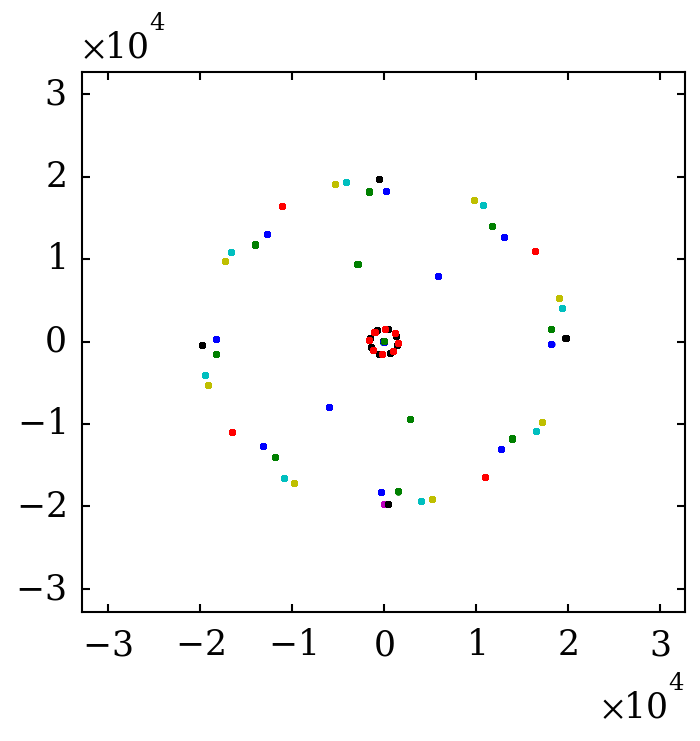

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))
for stream in streams:
    ax.plot(stream.s21_raw.real, stream.s21_raw.imag, '.')
ax.set_xlim(-2**15, 2**15)
ax.set_ylim(-2**15, 2**15)
#ax.legend(loc='best', fontsize=3)

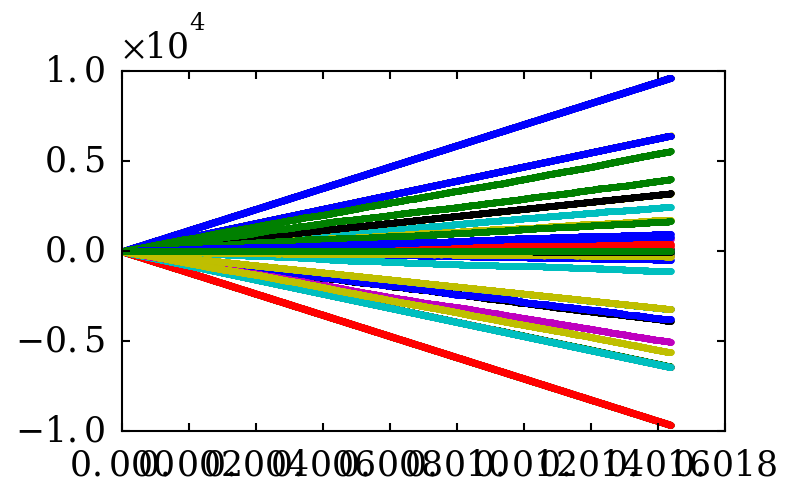

In [14]:
fig, ax = plt.subplots()
for stream in streams:
    ax.plot(stream.sample_time, np.unwrap(np.angle(stream.s21_raw)), '.')

# Center channel

In [15]:
center_index = len(streams) // 2
center = streams[center_index]
center.frequency

3100000000.0

In [16]:
np.log2(center.s21_raw.size)

12.0

In [17]:
s, f = plt.mlab.psd(center.s21_raw, Fs=center.stream_sample_rate, NFFT=center.s21_raw.size, noverlap=0, 
                    window=plt.mlab.window_none, sides='onesided')
edges, counts, fb, (sb,) = binning.log_bin(f[1:-1], 10, s[1:-1])

(1e-05, 0.1)

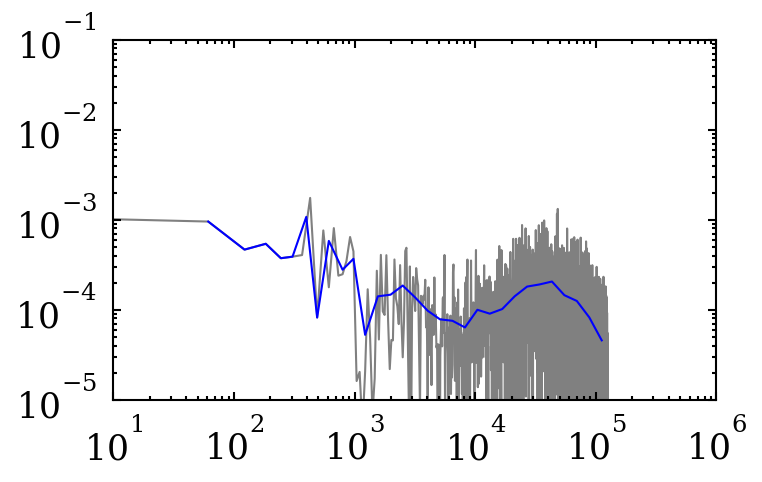

In [18]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(f, s, '-', color='gray')
ax.plot(fb, sb, '-', color='blue')
ax.plot()
ax.set_ylim(1e-5, 1e-1)

# Demodulated data

In [19]:
s21_demod = demodulate_data(center)

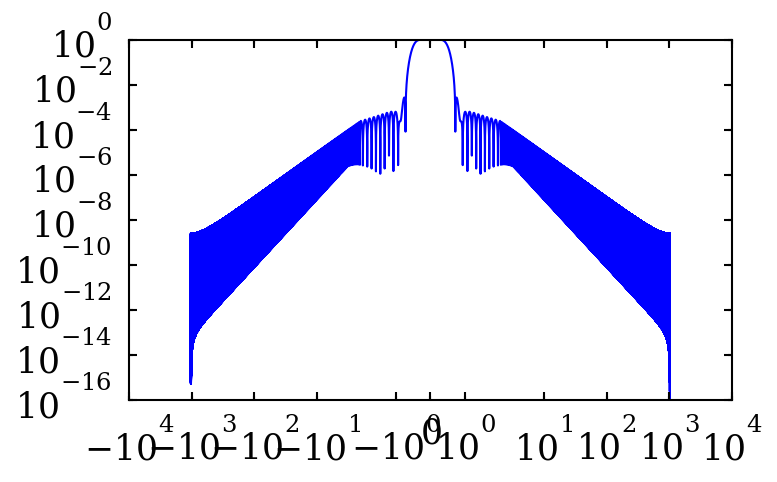

In [20]:
fig, ax = plt.subplots()
ax.set_xscale('symlog')
ax.set_yscale('log')
ax.plot(demod._window_frequency, demod._window_response)

In [21]:
sd, fd = plt.mlab.psd(s21_demod, Fs=center.stream_sample_rate, NFFT=s21_demod.size, noverlap=0,
                      window=plt.mlab.window_none, sides='onesided')
edges, counts, fdb, (sdb,) = binning.log_bin(fd[1:-1], 10, sd[1:-1])

(1e-05, 0.1)

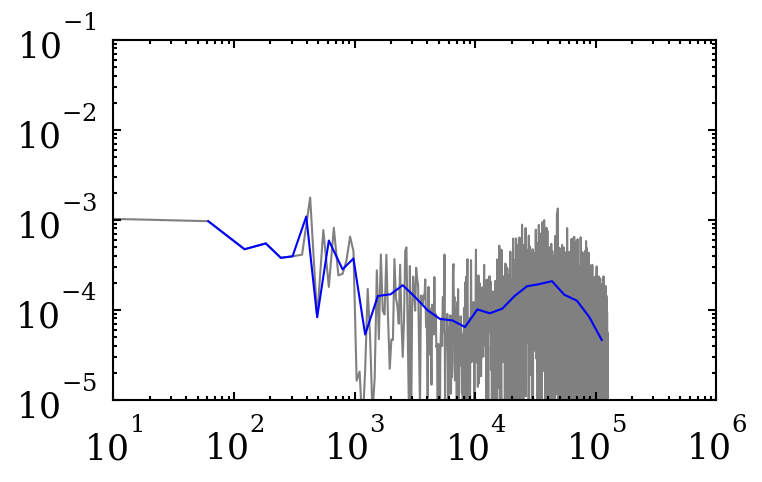

In [22]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(fd, sd, '-', color='gray')
ax.plot(fdb, sdb, '-', color='blue')
ax.plot()
ax.set_ylim(1e-5, 1e-1)

(1e-05, 0.1)

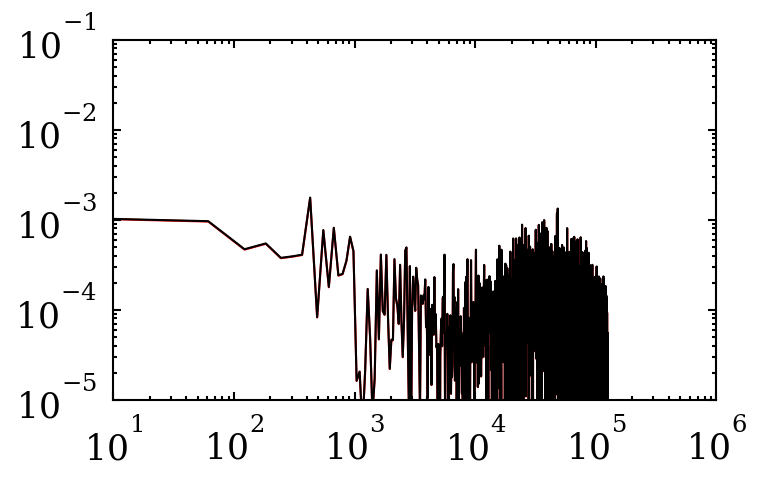

In [23]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(f, s, '-', color='red')
ax.plot(fd, sd, '-', color='black')
ax.plot()
ax.set_ylim(1e-5, 1e-1)

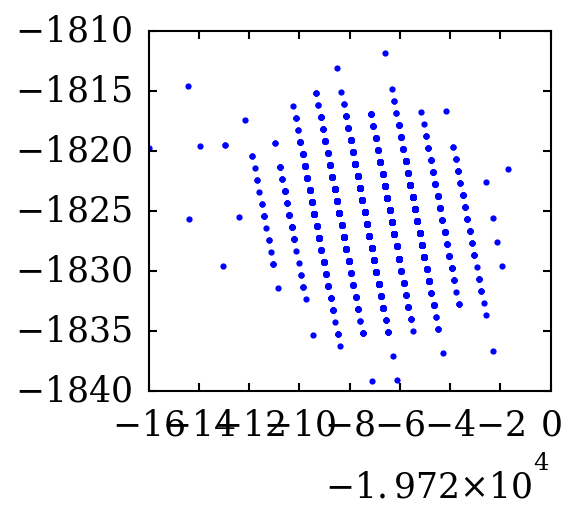

In [24]:
fig, ax = plt.subplots(figsize=(2, 2))
ax.plot(s21_demod.real, s21_demod.imag, '.b')

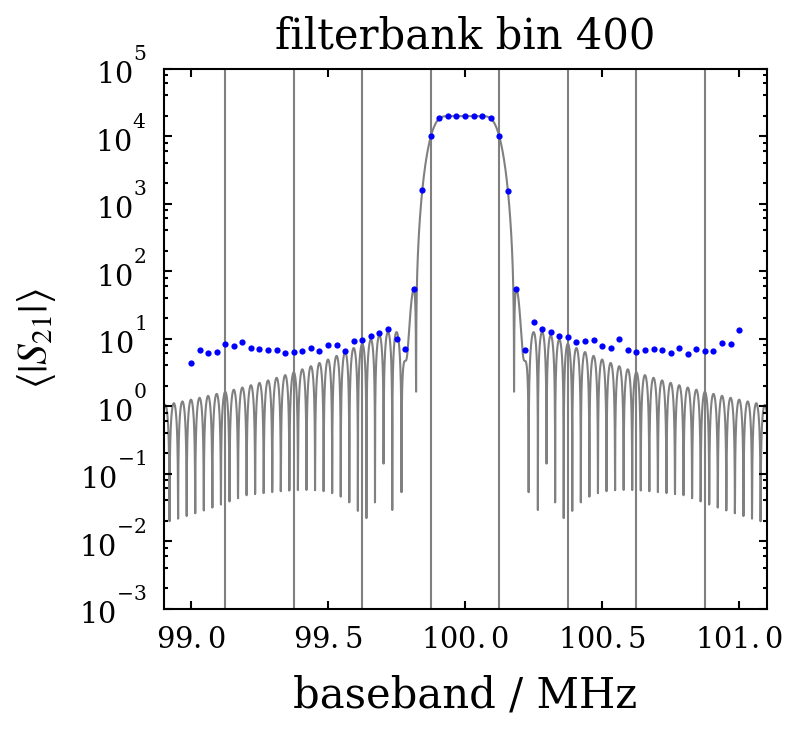

In [25]:
f_scale = 1e-6
f_center = 100e6
filterbank_bin_edges = f_filterbank * np.arange(n_filterbank - 4.5, n_filterbank + 5.5)

fig, ax = plt.subplots(figsize=(3, 3))
ax.set_xlabel('baseband / MHz')
ax.set_ylabel(r'$\langle |S_{21}| \rangle$')

ax.plot(f_scale * (f_center + f_filterbank * demod._window_frequency),
        np.mean(np.abs(center.s21_raw)) * demod._window_response,
        '-', color='gray')
for edge in filterbank_bin_edges:
    ax.axvline(f_scale * edge, color='gray')
for stream in streams:
    ax.semilogy(f_scale * (stream.frequency - stream.roach_state.lo_frequency),
                np.mean(np.abs(stream.s21_raw)),
                '.b')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.set_xlim(98.9, 101.1)
#ax.set_xticks([99.9, 100, 100.1])
ax.set_ylim(1e-3, 1e5)
ax.tick_params(labelsize='xx-small')
ax.set_title('filterbank bin {:.0f}'.format(stream.filterbank_bin))

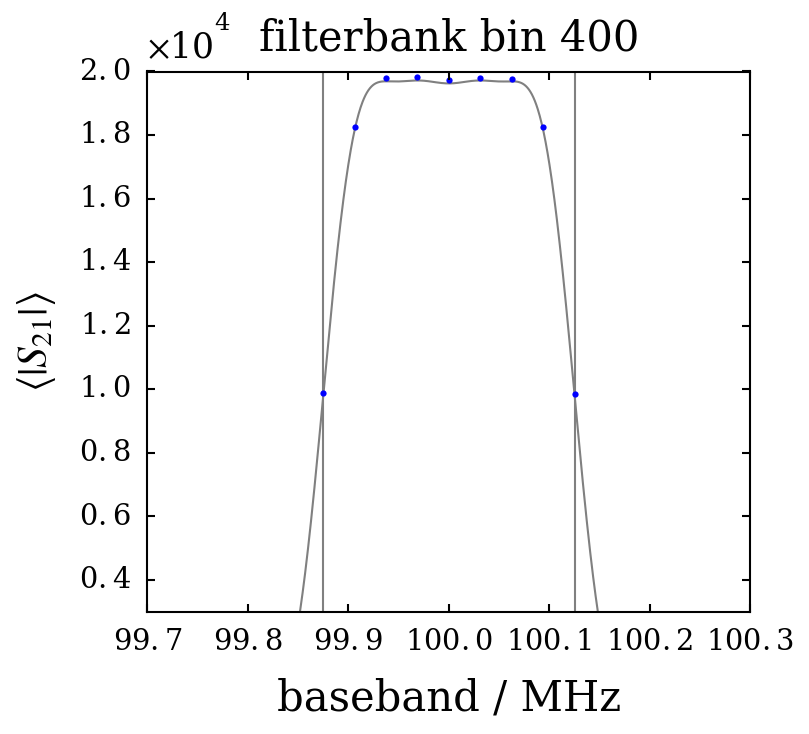

In [26]:
f_scale = 1e-6
f_center = 100e6
filterbank_bin_edges = f_filterbank * np.arange(n_filterbank - 1.5, n_filterbank + 2.5)

fig, ax = plt.subplots(figsize=(3, 3))
ax.set_xlabel('baseband / MHz')
ax.set_ylabel(r'$\langle |S_{21}| \rangle$')

ax.plot(f_scale * (f_center + f_filterbank * demod._window_frequency),
        np.mean(np.abs(center.s21_raw)) * demod._window_response,
        '-', color='gray')
for edge in filterbank_bin_edges:
    ax.axvline(f_scale * edge, color='gray')
for stream in streams:
    ax.plot(f_scale * (stream.frequency - stream.roach_state.lo_frequency),
                np.mean(np.abs(stream.s21_raw)),
                '.b')
ax.get_xaxis().get_major_formatter().set_useOffset(False)
ax.set_xlim(99.7, 100.3)
ax.set_ylim(3e3, 2e4)
#ax.set_xticks([99.9, 100, 100.1])
ax.tick_params(labelsize='xx-small')
ax.set_title('filterbank bin {:.0f}'.format(stream.filterbank_bin))

# PSDs on either side of the center channel

In [27]:
def analyze(ss):
    ss.s21_demod = demodulate_data(ss)
    ss.S_demod, ss.f_demod = plt.mlab.psd(ss.s21_demod, Fs=ss.stream_sample_rate,
                                          NFFT=ss.s21_demod.size, noverlap=0,
                                          window=plt.mlab.window_hanning, detrend=plt.mlab.detrend_none,
                                          sides='onesided')
    edges, counts, fd, (sd,) = binning.log_bin(ss.f_demod[1:-1], 10, ss.S_demod[1:-1])
    ss.f_demod_binned = fd
    ss.S_demod_binned = sd

In [28]:
offsets = range(-4, 5)
mappable = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=min(offsets), vmax=max(offsets)),
                                 cmap=plt.cm.plasma)

In [29]:
for offset in offsets:
    analyze(streams[center_index + offset])

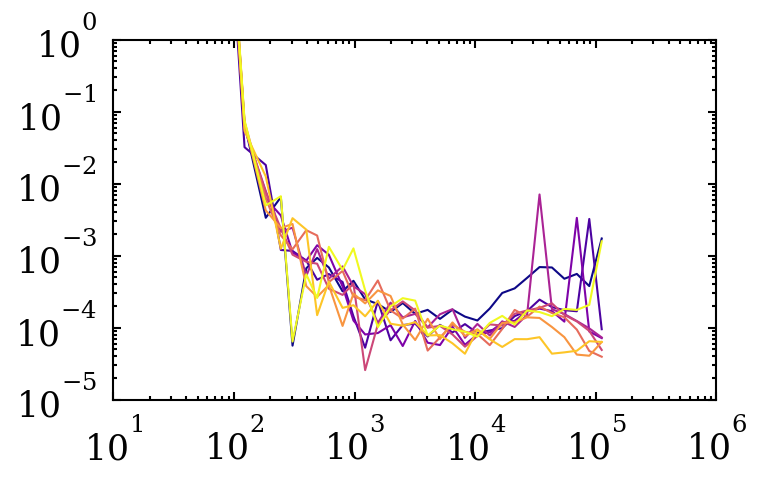

In [30]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
for offset in offsets:
    ss = streams[center_index + offset]
    ax.plot(ss.f_demod_binned, ss.S_demod_binned, label=str(offset),
            color=mappable.to_rgba(offset), alpha=1)
ax.set_ylim(1e-5, 1e0);

(0, 0.001)

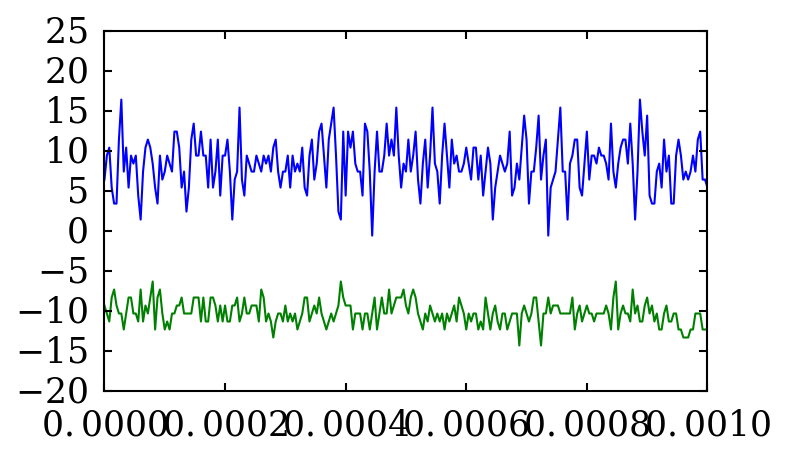

In [31]:
fig, ax = plt.subplots()
ax.plot(center.sample_time, center.s21_raw.real - center.s21_raw.real.mean() + 10, '-b')
ax.plot(center.sample_time, center.s21_raw.imag - center.s21_raw.imag.mean() - 10, '-g')
ax.set_xlim(0, 0.001)

In [32]:
center.s21_raw.real.std()

3.5473223

In [33]:
center.s21_raw.imag.std()

1.4789535

In [34]:
center.s21_raw.real.mean()

-5.46875

In [35]:
center.s21_raw.imag.mean()

-19717.729

(0, 0.001)

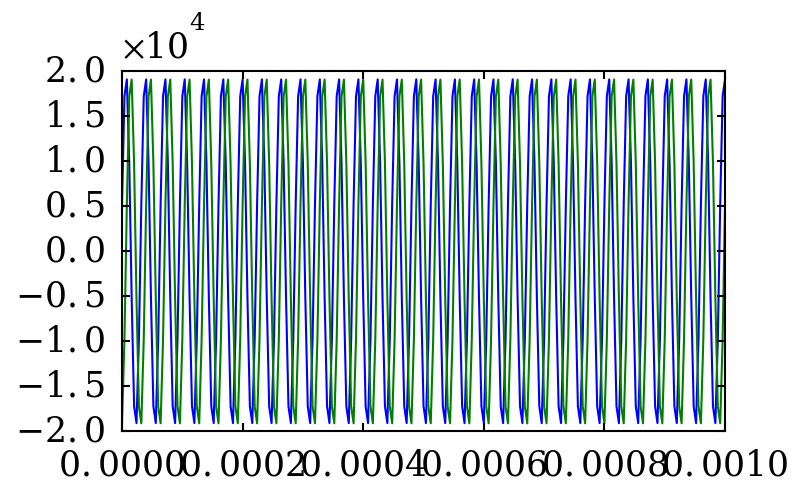

In [36]:
right = streams[center_index + 1]
fig, ax = plt.subplots()
ax.plot(right.sample_time, right.s21_raw.real - right.s21_raw.real.mean() + 10, '-b')
ax.plot(right.sample_time, right.s21_raw.imag - right.s21_raw.imag.mean() - 10, '-g')
ax.set_xlim(0, 0.001)

# Two-sided PSDs and aliasing

In [37]:
for ss in streams:
    ss.S_twosided, ss.f_twosided = plt.mlab.psd(ss.s21_raw, Fs=ss.stream_sample_rate,
                                                NFFT=ss.s21_raw.size // 2**4, noverlap=ss.s21_raw.size // 2**5,
                                                window=plt.mlab.window_hanning, detrend=plt.mlab.detrend_none,
                                                sides='twosided')

In [38]:
offset_mappable = plt.cm.ScalarMappable(norm=mpl.colors.Normalize(vmin=streams[0].tone_offset_frequency()[0],
                                                                  vmax=streams[-1].tone_offset_frequency()[0]),
                                        cmap=plt.cm.plasma)

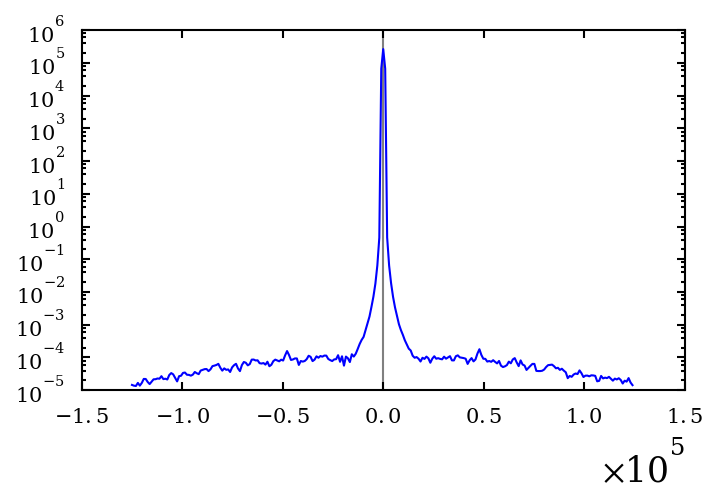

In [39]:
fig, ax = plt.subplots()
ss = streams[center_index]
ax.set_yscale('log')
#ax.set_ylim(1e-5, 1e-1)
#ax.set_xlim(-1e3, 1e3)
ax.tick_params(labelsize=5)
nf_offset = ss.tone_offset_frequency()[0]
f_wrapped = (f_filterbank * nf_offset + f_filterbank / 2) % f_filterbank - f_filterbank / 2
ax.axvline(f_wrapped, color='gray')
ax.plot(ss.f_twosided, ss.S_twosided)

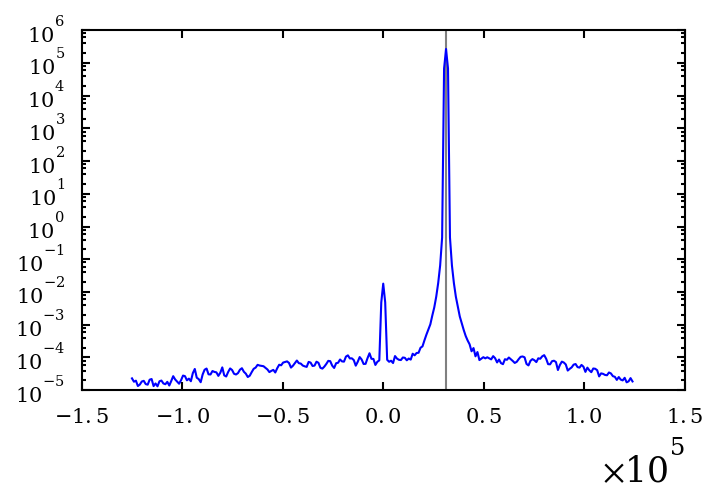

In [40]:
fig, ax = plt.subplots()
ss = streams[center_index + 1]
ax.set_yscale('log')
#ax.set_ylim(1e-5, 1e-1)
#ax.set_xlim(-1e3, 1e3)
ax.tick_params(labelsize=5)
nf_offset = ss.tone_offset_frequency()[0]
f_wrapped = (f_filterbank * nf_offset + f_filterbank / 2) % f_filterbank - f_filterbank / 2
ax.axvline(f_wrapped, color='gray')
ax.plot(ss.f_twosided, ss.S_twosided)

In [41]:
print(range(-center_index, center_index + 1))

[-32, -31, -30, -29, -28, -27, -26, -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]


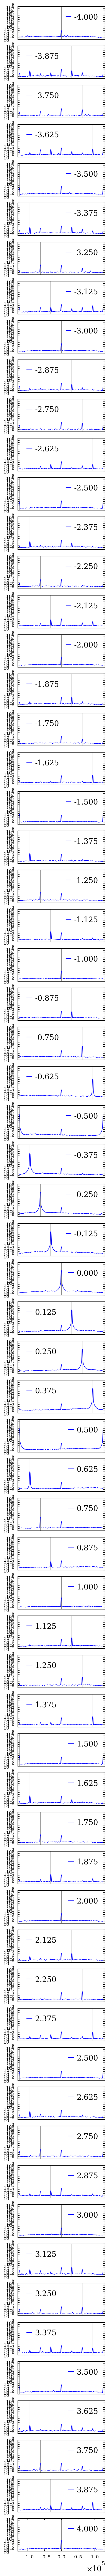

In [42]:
offsets = range(-center_index, center_index + 1)
fig, axes = plt.subplots(len(offsets), 1, figsize=(2, len(offsets)))
for offset, ax in zip(offsets, axes.flatten()):
    ss = streams[center_index + offset]
    ax.set_yscale('log')
    ax.set_ylim(1e-6, 1e9)
    ax.set_xlim(-130e3, 130e3)
    ax.set_xticks([])
    ax.tick_params(labelsize=5)
    nf_offset = ss.tone_offset_frequency()[0]
    f_wrapped = (f_filterbank * nf_offset + f_filterbank / 2) % f_filterbank - f_filterbank / 2
    ax.axvline(f_wrapped, color='gray')
    ax.plot(ss.f_twosided, ss.S_twosided, label='{:.3f}'.format(nf_offset))
    ax.legend(loc='best')

axes[-1].set_xticks(np.linspace(-100e3, 100e3, 5));

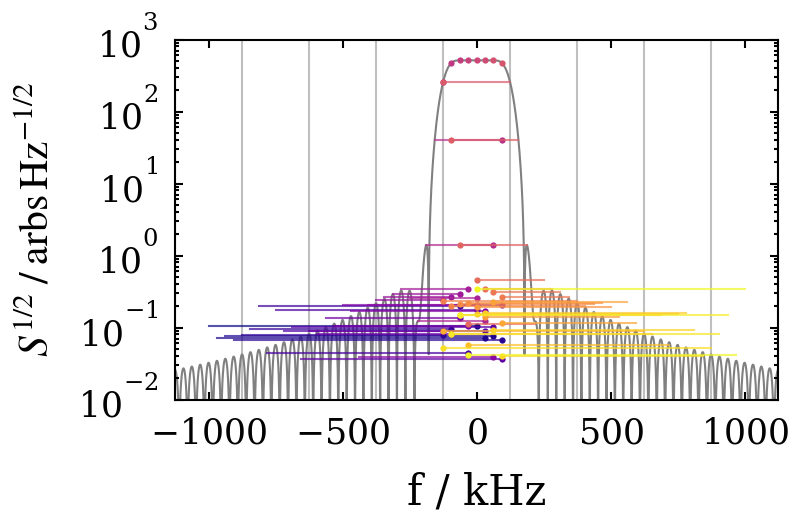

In [43]:
f_scale = 1e-3
centered_bin_edges = f_filterbank * np.arange(-4.5, 5.5)

fig, ax = plt.subplots()
ax.set_yscale('log')
ax.set_xlim(f_scale * centered_bin_edges[0], f_scale * centered_bin_edges[-1])
ax.set_ylim(1e-2, 1e3)
ax.set_xlabel('f / kHz')
ax.set_ylabel('$S^{1/2} \; / \; \mathrm{arbs} \, \mathrm{Hz}^{-1/2}$')

ax.plot(f_scale * f_filterbank * demod._window_frequency,
        center.S_twosided[np.where(center.f_twosided==0)[0]]**(1/2) * demod._window_response,
        '-', color='gray')
for edge in centered_bin_edges:
    ax.axvline(f_scale * edge, color='gray', alpha=0.5)
for offset in offsets:
    ss = streams[center_index + offset]
    nf_offset = ss.tone_offset_frequency()[0]
    f_wrapped = (f_filterbank * nf_offset + f_filterbank / 2) % f_filterbank - f_filterbank / 2
    S_wrapped = ss.S_twosided[np.argmin(np.abs(ss.f_twosided - f_wrapped))]**(1/2)
    ax.plot([f_scale * f_filterbank * nf_offset, f_scale * f_wrapped],
            [S_wrapped, S_wrapped],
            '-', alpha=0.7, color=offset_mappable.to_rgba(nf_offset))
    ax.plot([f_scale * f_wrapped], [S_wrapped],
            '.', color=offset_mappable.to_rgba(nf_offset))

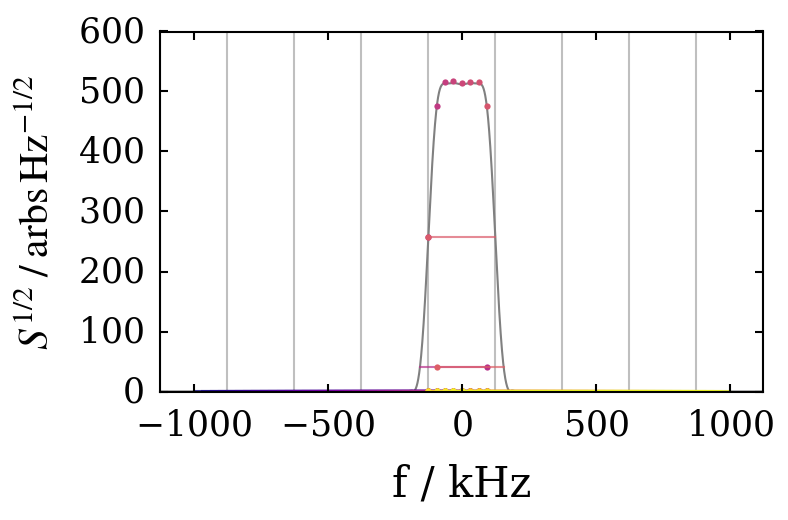

In [44]:
f_scale = 1e-3
centered_bin_edges = f_filterbank * np.arange(-4.5, 5.5)

fig, ax = plt.subplots()
#ax.set_yscale('log')
ax.set_xlim(f_scale * centered_bin_edges[0], f_scale * centered_bin_edges[-1])
#ax.set_ylim(1e-2, 1e3)
ax.set_xlabel('f / kHz')
ax.set_ylabel('$S^{1/2} \; / \; \mathrm{arbs} \, \mathrm{Hz}^{-1/2}$')

ax.plot(f_scale * f_filterbank * demod._window_frequency,
        center.S_twosided[np.where(center.f_twosided==0)[0]]**(1/2) * demod._window_response,
        '-', color='gray')
for edge in centered_bin_edges:
    ax.axvline(f_scale * edge, color='gray', alpha=0.5)
for offset in offsets:
    ss = streams[center_index + offset]
    nf_offset = ss.tone_offset_frequency()[0]
    f_wrapped = (f_filterbank * nf_offset + f_filterbank / 2) % f_filterbank - f_filterbank / 2
    S_wrapped = ss.S_twosided[np.argmin(np.abs(ss.f_twosided - f_wrapped))]**(1/2)
    ax.plot([f_scale * f_filterbank * nf_offset, f_scale * f_wrapped],
            [S_wrapped, S_wrapped],
            '-', alpha=0.7, color=offset_mappable.to_rgba(nf_offset))
    ax.plot([f_scale * f_wrapped], [S_wrapped],
            '.', color=offset_mappable.to_rgba(nf_offset))